### Necessary imports
Imports all necessary packages for this project

In [ ]:
# import libraries
import pandas as pd
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from langdetect import detect, DetectorFactory
from deep_translator import GoogleTranslator
import pickle

### Dataset
The cybersecurity job market is constantly evolving, and LinkedIn hosts numerous job advertisements related to the field. To ensure the dataset reflects current real-world demands, updated job postings were collected.

After some research, a useful Chrome extension was identified:

**ScrapeJob – LinkedIn Jobs Scraper:**

With proper configuration, this tool extracts job listings, company details, and job poster information from LinkedIn postings.

For more details, visit:
https://linkedin.scrapejob.net/

In [ ]:
# try loading a saved state for the preprocessed dataframe
try:
    with open('df_state.pkl', 'rb') as f:
        df = pickle.load(f)
except FileNotFoundError:
    print("No saved state found. Run preprocessing...")

In [22]:
# load the data
data = pd.read_json('data/li_jobs.json')

### Data exploration

In [23]:
# number of rows / samples
row_count = data.shape[0]
row_count

2086

In [24]:
# print the first few rows of the data
data.head()

,Title,Description,Primary Description,Detail URL,Location,Skill,Insight,Job State,Poster Id,Company Name,...,Headquarters,Company Founded,Specialties,Hiring Manager Title,Hiring Manager Subtitle,Hiring Manager Title Insight,Hiring Manager Profile,Hiring Manager Image,Created At,Scraped At
0,Mitarbeiter Organisationsmanagement & Prozesso...,Standort: Lohr a.MainBeschäftigungsverhältnis:...,Raiffeisen Immobilien-Dienstleistungs GmbH · L...,https://www.linkedin.com/jobs/view/4169550707,"Lohr, Bavaria, Germany","Skills: Spanish, Artificial Intelligence (AI),...",,LISTED,1479512611,,...,,,,,,,,,2025-02-28T14:24:34.000Z,2025-03-04T20:51:54.642Z
1,Senior Operations & Automation Manager – Label...,\n\nYour mission\n\n\n\nAbout Label OS\n\nLabe...,"iGroove · Berlin, Berlin, Germany (On-site)",https://www.linkedin.com/jobs/view/4144186025,"Berlin, Berlin, Germany","Skills: Soft Skills, Data Analytics, +8 more",,LISTED,222132374,iGroove,...,Pfäffikon,2013,"Digital Music Distribution,Label Services,Arti...",Patrick Lawritsch,COO iGroove // Entrepreneur | Trusted Expert \...,3rd,https://www.linkedin.com/in/plawritsch,https://media.licdn.com/dms/image/v2/C4D03AQGV...,2025-02-07T18:59:15.000Z,2025-03-04T20:52:05.978Z
2,Middelbaar Veiligheidskundige,Ben jij dé specialist in arbeidsveiligheid en ...,"Groothuis Bouw Emmeloord · Emmeloord, Flevolan...",https://www.linkedin.com/jobs/view/4118527660,"Emmeloord, Flevoland, Netherlands",,,LISTED,653913933,Groothuis Bouw Emmeloord,...,Emmeloord,,"Het bouwen van vrijstaande woningen,Traditione...",,,,,,2025-01-07T12:08:16.000Z,2025-03-04T20:52:16.825Z
3,Security consultant - SIEM,Hľadáme odborníka na technológiu SIEM a oblasť...,"exe, a.s. · Bratislava Metropolitan Area (Hybrid)",https://www.linkedin.com/jobs/view/4153637949,Bratislava Metropolitan Area,"Skills: Information Security, Cybersecurity, +...",,LISTED,449502629,"exe, a.s.",...,Bratislava,1990,"Projecting Enterprise Information Systems,Soft...",,,,,,2025-02-18T06:43:37.000Z,2025-03-04T20:52:28.790Z
4,Information Technology Graduate,"CityLearning, a leading provider of compliance...","CityLearning · Dublin, County Dublin, Ireland ...",https://www.linkedin.com/jobs/view/4170246916,"Dublin, County Dublin, Ireland",8 of 10 skills match your profile - you may be...,,LISTED,72468613,CityLearning,...,Dublin 2,1998,"GDPR,Data Protection,Combat Money Laundering,I...",,,,,,2025-03-01T12:42:16.000Z,2025-03-04T20:52:39.856Z


In [25]:
data.columns

Index(['Title', 'Description', 'Primary Description', 'Detail URL', 'Location',
       'Skill', 'Insight', 'Job State', 'Poster Id', 'Company Name',
       'Company Description', 'Company Website', 'Company Logo',
       'Company Apply Url', 'Industry', 'Employee Count', 'Headquarters',
       'Company Founded', 'Specialties', 'Hiring Manager Title',
       'Hiring Manager Subtitle', 'Hiring Manager Title Insight',
       'Hiring Manager Profile', 'Hiring Manager Image', 'Created At',
       'Scraped At'],
      dtype='object')

### Building a DataFrame

In [26]:
# convert data to a DataFrame
df = pd.DataFrame(data)

### Preprocessing

**Cleaning the DataFrame:** drop unneeded columns

In [27]:
# Drop hiring manager-related columns, scrape info, non needed columns
columns_to_drop = [
    "Headquarters", "Company Apply Url", "Company Founded", "Company Logo",
    "Hiring Manager Title", "Hiring Manager Subtitle", "Hiring Manager Title Insight", 
    "Hiring Manager Profile", "Hiring Manager Image", "Created At",
    "Scraped At", "Insight", "Job State",
]
df.drop(columns=columns_to_drop, errors="ignore", inplace=True)


df.columns

Index(['Title', 'Description', 'Primary Description', 'Detail URL', 'Location',
       'Skill', 'Poster Id', 'Company Name', 'Company Description',
       'Company Website', 'Industry', 'Employee Count', 'Specialties'],
      dtype='object')

**Handling missing values**

In [28]:
# check for missing values
(df == "").sum()

Title                    0
Description              0
Primary Description      0
Detail URL               0
Location                 0
Skill                  187
Poster Id                1
Company Name            17
Company Description      8
Company Website         16
Industry                 7
Employee Count           8
Specialties             88
dtype: int64

**Removing \n from descriptions**

In [29]:
df["Description"] = df["Description"].str.replace("\n", ". ", regex=True)
df["Company Description"] = df["Company Description"].str.replace("\n", ". ", regex=True)

In [30]:
# print the first few rows of the DataFrame
df.head(30)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties
0,Mitarbeiter Organisationsmanagement & Prozesso...,Standort: Lohr a.MainBeschäftigungsverhältnis:...,Raiffeisen Immobilien-Dienstleistungs GmbH · L...,https://www.linkedin.com/jobs/view/4169550707,"Lohr, Bavaria, Germany","Skills: Spanish, Artificial Intelligence (AI),...",1479512611,,,,,,
1,Senior Operations & Automation Manager – Label...,. . Your mission. . . . About Label OS. . Labe...,"iGroove · Berlin, Berlin, Germany (On-site)",https://www.linkedin.com/jobs/view/4144186025,"Berlin, Berlin, Germany","Skills: Soft Skills, Data Analytics, +8 more",222132374,iGroove,Your music business has a home. Find it all in...,http://www.igroovemusic.com,Music,33,"Digital Music Distribution,Label Services,Arti..."
2,Middelbaar Veiligheidskundige,Ben jij dé specialist in arbeidsveiligheid en ...,"Groothuis Bouw Emmeloord · Emmeloord, Flevolan...",https://www.linkedin.com/jobs/view/4118527660,"Emmeloord, Flevoland, Netherlands",,653913933,Groothuis Bouw Emmeloord,Wij zijn Groothuisbouw. Het bouwbedrijf dat ho...,http://www.groothuisbouw.nl,Construction,139,"Het bouwen van vrijstaande woningen,Traditione..."
3,Security consultant - SIEM,Hľadáme odborníka na technológiu SIEM a oblasť...,"exe, a.s. · Bratislava Metropolitan Area (Hybrid)",https://www.linkedin.com/jobs/view/4153637949,Bratislava Metropolitan Area,"Skills: Information Security, Cybersecurity, +...",449502629,"exe, a.s.","Since 1990, exe, a.s. offers complex services ...",http://www.exe.sk,Information Technology & Services,120,"Projecting Enterprise Information Systems,Soft..."
4,Information Technology Graduate,"CityLearning, a leading provider of compliance...","CityLearning · Dublin, County Dublin, Ireland ...",https://www.linkedin.com/jobs/view/4170246916,"Dublin, County Dublin, Ireland",8 of 10 skills match your profile - you may be...,72468613,CityLearning,"At CityLearning, we specialise in simplifying ...",http://www.citylearning.com,E-learning,20,"GDPR,Data Protection,Combat Money Laundering,I..."
5,Systeem en netwerkbeheerder met security affin...,Als Security Systeem- en Netwerkbeheerder bij ...,"Fortytwo Security · Amsterdam, North Holland, ...",https://www.linkedin.com/jobs/view/4033998205,"Amsterdam, North Holland, Netherlands","Skills: Linux, Infrastructure, +5 more",16756817,Fortytwo Security,Fortytwo Security is a premier cybersecurity a...,https://fortytwo.nl/,Information Technology & Services,11,"PCI-DSS QSA,Security Audits,Penetration testin..."
6,Data Engineer,Job Description:We are seeking a skilled Data ...,JSS ASSOCIATES · Warsaw Metropolitan Area (Hy...,https://www.linkedin.com/jobs/view/4172639382,Warsaw Metropolitan Area,2 of 3 skills match your profile - you may be ...,1032479549,JSS ASSOCIATES,JSS Associates is a specialized IT recruitment...,http://www.jssassociates.co.uk,Information Technology & Services,26,
7,Addetto Reparto ICT,Azienda L'azienda promotrice della ricerca ha ...,"Webb James · Livorno, Tuscany, Italy (On-site)",https://www.linkedin.com/jobs/view/4059057213,"Livorno, Tuscany, Italy","Skills: Communication, C#, +5 more",221770032,Webb James,Webb James dal 1793 è attiva nel settore impor...,http://www.webbjames.com,Food Production,19,
8,IT Security Consultant (m/w/d),. . Du bringst bereits fundierte Erfahrung im ...,"hagebau IT GmbH · Soltau, Lower Saxony, German...",https://www.linkedin.com/jobs/view/4157198667,"Soltau, Lower Saxony, Germany","Skills: Information Security, Cybersecurity, +...",143855271,hagebau IT GmbH,Die hagebau IT GmbH mit Sitz im niedersächsisc...,https://hagebau.com/unternehmen/beteiligungen/...,Information Technology & Services,104,
9,Artificial Intelligence Specialist,*** Gestalte die Zukunft der generativen KI mi...,FindYou Consulting GmbH · Germany (Remote),https://www.linkedin.com/jobs/view/4173647017,Germany,5 of 8 skills match your profile - you ma

**Cleaning the DataFrame:** Remove irrelevant information from skill-related columns, as these contain personalized recommendations based on the (personal) account used for scraping.

In [31]:
# Preprocess the Skill column
def clean_skills(skill_str):
    if isinstance(skill_str, str):
        # Remove "Skills: " if it appears at the beginning
        skill_str = re.sub(r"^Skills:\s*", "", skill_str).strip()
        # Remove "X of Y skills match your profile - you may be ..." pattern
        skill_str = re.sub(r"\d+\s+of\s+\d+\s+skills match your profile - you may be.*", "", skill_str, flags=re.IGNORECASE).strip()
        # Remove ", +X more" where X is any number
        skill_str = re.sub(r",\s\+\d+\s+more", "", skill_str).strip()
        return skill_str
    return ""

In [32]:
df["Skill"] = df["Skill"].apply(clean_skills)
df.head(20)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties
0,Mitarbeiter Organisationsmanagement & Prozesso...,Standort: Lohr a.MainBeschäftigungsverhältnis:...,Raiffeisen Immobilien-Dienstleistungs GmbH · L...,https://www.linkedin.com/jobs/view/4169550707,"Lohr, Bavaria, Germany","Spanish, Artificial Intelligence (AI)",1479512611,,,,,,
1,Senior Operations & Automation Manager – Label...,. . Your mission. . . . About Label OS. . Labe...,"iGroove · Berlin, Berlin, Germany (On-site)",https://www.linkedin.com/jobs/view/4144186025,"Berlin, Berlin, Germany","Soft Skills, Data Analytics",222132374,iGroove,Your music business has a home. Find it all in...,http://www.igroovemusic.com,Music,33,"Digital Music Distribution,Label Services,Arti..."
2,Middelbaar Veiligheidskundige,Ben jij dé specialist in arbeidsveiligheid en ...,"Groothuis Bouw Emmeloord · Emmeloord, Flevolan...",https://www.linkedin.com/jobs/view/4118527660,"Emmeloord, Flevoland, Netherlands",,653913933,Groothuis Bouw Emmeloord,Wij zijn Groothuisbouw. Het bouwbedrijf dat ho...,http://www.groothuisbouw.nl,Construction,139,"Het bouwen van vrijstaande woningen,Traditione..."
3,Security consultant - SIEM,Hľadáme odborníka na technológiu SIEM a oblasť...,"exe, a.s. · Bratislava Metropolitan Area (Hybrid)",https://www.linkedin.com/jobs/view/4153637949,Bratislava Metropolitan Area,"Information Security, Cybersecurity",449502629,"exe, a.s.","Since 1990, exe, a.s. offers complex services ...",http://www.exe.sk,Information Technology & Services,120,"Projecting Enterprise Information Systems,Soft..."
4,Information Technology Graduate,"CityLearning, a leading provider of compliance...","CityLearning · Dublin, County Dublin, Ireland ...",https://www.linkedin.com/jobs/view/4170246916,"Dublin, County Dublin, Ireland",,72468613,CityLearning,"At CityLearning, we specialise in simplifying ...",http://www.citylearning.com,E-learning,20,"GDPR,Data Protection,Combat Money Laundering,I..."
5,Systeem en netwerkbeheerder met security affin...,Als Security Systeem- en Netwerkbeheerder bij ...,"Fortytwo Security · Amsterdam, North Holland, ...",https://www.linkedin.com/jobs/view/4033998205,"Amsterdam, North Holland, Netherlands","Linux, Infrastructure",16756817,Fortytwo Security,Fortytwo Security is a premier cybersecurity a...,https://fortytwo.nl/,Information Technology & Services,11,"PCI-DSS QSA,Security Audits,Penetration testin..."
6,Data Engineer,Job Description:We are seeking a skilled Data ...,JSS ASSOCIATES · Warsaw Metropolitan Area (Hy...,https://www.linkedin.com/jobs/view/4172639382,Warsaw Metropolitan Area,,1032479549,JSS ASSOCIATES,JSS Associates is a specialized IT recruitment...,http://www.jssassociates.co.uk,Information Technology & Services,26,
7,Addetto Reparto ICT,Azienda L'azienda promotrice della ricerca ha ...,"Webb James · Livorno, Tuscany, Italy (On-site)",https://www.linkedin.com/jobs/view/4059057213,"Livorno, Tuscany, Italy","Communication, C#",221770032,Webb James,Webb James dal 1793 è attiva nel settore impor...,http://www.webbjames.com,Food Production,19,
8,IT Security Consultant (m/w/d),. . Du bringst bereits fundierte Erfahrung im ...,"hagebau IT GmbH · Soltau, Lower Saxony, German...",https://www.linkedin.com/jobs/view/4157198667,"Soltau, Lower Saxony, Germany","Information Security, Cybersecurity",143855271,hagebau IT GmbH,Die hagebau IT GmbH mit Sitz im niedersächsisc...,https://hagebau.com/unternehmen/beteiligungen/...,Information Technology & Services,104,
9,Artificial Intelligence Specialist,*** Gestalte die Zukunft der generativen KI mi...,FindYou Consulting GmbH · Germany (Remote),https://www.linkedin.com/jobs/view/4173647017,Germany,,803746641,FindYou Consulting GmbH,Welcome to FindYou - Happy to have you here!. ...,www.findyou.de,Staffing & Recruiting,7,"Recruiting,Personalberatung,Personalvermittlun..."


**Converting data types**

In [33]:
df["Employee Count"] = pd.to_numeric(df["Employee Count"], errors="coerce")

In [34]:
df.head(20)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties
0,Mitarbeiter Organisationsmanagement & Prozesso...,Standort: Lohr a.MainBeschäftigungsverhältnis:...,Raiffeisen Immobilien-Dienstleistungs GmbH · L...,https://www.linkedin.com/jobs/view/4169550707,"Lohr, Bavaria, Germany","Spanish, Artificial Intelligence (AI)",1479512611,,,,,NaN,
1,Senior Operations & Automation Manager – Label...,. . Your mission. . . . About Label OS. . Labe...,"iGroove · Berlin, Berlin, Germany (On-site)",https://www.linkedin.com/jobs/view/4144186025,"Berlin, Berlin, Germany","Soft Skills, Data Analytics",222132374,iGroove,Your music business has a home. Find it all in...,http://www.igroovemusic.com,Music,33.0,"Digital Music Distribution,Label Services,Arti..."
2,Middelbaar Veiligheidskundige,Ben jij dé specialist in arbeidsveiligheid en ...,"Groothuis Bouw Emmeloord · Emmeloord, Flevolan...",https://www.linkedin.com/jobs/view/4118527660,"Emmeloord, Flevoland, Netherlands",,653913933,Groothuis Bouw Emmeloord,Wij zijn Groothuisbouw. Het bouwbedrijf dat ho...,http://www.groothuisbouw.nl,Construction,139.0,"Het bouwen van vrijstaande woningen,Traditione..."
3,Security consultant - SIEM,Hľadáme odborníka na technológiu SIEM a oblasť...,"exe, a.s. · Bratislava Metropolitan Area (Hybrid)",https://www.linkedin.com/jobs/view/4153637949,Bratislava Metropolitan Area,"Information Security, Cybersecurity",449502629,"exe, a.s.","Since 1990, exe, a.s. offers complex services ...",http://www.exe.sk,Information Technology & Services,120.0,"Projecting Enterprise Information Systems,Soft..."
4,Information Technology Graduate,"CityLearning, a leading provider of compliance...","CityLearning · Dublin, County Dublin, Ireland ...",https://www.linkedin.com/jobs/view/4170246916,"Dublin, County Dublin, Ireland",,72468613,CityLearning,"At CityLearning, we specialise in simplifying ...",http://www.citylearning.com,E-learning,20.0,"GDPR,Data Protection,Combat Money Laundering,I..."
5,Systeem en netwerkbeheerder met security affin...,Als Security Systeem- en Netwerkbeheerder bij ...,"Fortytwo Security · Amsterdam, North Holland, ...",https://www.linkedin.com/jobs/view/4033998205,"Amsterdam, North Holland, Netherlands","Linux, Infrastructure",16756817,Fortytwo Security,Fortytwo Security is a premier cybersecurity a...,https://fortytwo.nl/,Information Technology & Services,11.0,"PCI-DSS QSA,Security Audits,Penetration testin..."
6,Data Engineer,Job Description:We are seeking a skilled Data ...,JSS ASSOCIATES · Warsaw Metropolitan Area (Hy...,https://www.linkedin.com/jobs/view/4172639382,Warsaw Metropolitan Area,,1032479549,JSS ASSOCIATES,JSS Associates is a specialized IT recruitment...,http://www.jssassociates.co.uk,Information Technology & Services,26.0,
7,Addetto Reparto ICT,Azienda L'azienda promotrice della ricerca ha ...,"Webb James · Livorno, Tuscany, Italy (On-site)",https://www.linkedin.com/jobs/view/4059057213,"Livorno, Tuscany, Italy","Communication, C#",221770032,Webb James,Webb James dal 1793 è attiva nel settore impor...,http://www.webbjames.com,Food Production,19.0,
8,IT Security Consultant (m/w/d),. . Du bringst bereits fundierte Erfahrung im ...,"hagebau IT GmbH · Soltau, Lower Saxony, German...",https://www.linkedin.com/jobs/view/4157198667,"Soltau, Lower Saxony, Germany","Information Security, Cybersecurity",143855271,hagebau IT GmbH,Die hagebau IT GmbH mit Sitz im niedersächsisc...,https://hagebau.com/unternehmen/beteiligungen/...,Information Technology & Services,104.0,
9,Artificial Intelligence Specialist,*** Gestalte die Zukunft der generativen KI mi...,FindYou Consulting GmbH · Germany (Remote),https://www.linkedin.com/jobs/view/4173647017,Germany,,803746641,FindYou Consulting GmbH,Welcome to FindYou - Happy to have you here!. ...,www.findyou.de,Staffing & Recruiting,7.0,"Recruiting,Personalberatung,Personalvermittlun..."


**Language Detection and Translation**:
Since the dataset consists of LinkedIn job ads from European countries, some postings are in English, while others appear in different European languages. To ensure consistency and meaningful analysis, all job descriptions need to be in English.

To achieve this, a preprocessing flow was implemented:

1. Language Detection: Each job ad is analyzed to determine its language.

2. Translation: If the ad is not in English, it is automatically translated.

3. Standardization: The final dataset contains all job postings in English, allowing for uniform text analysis.

In [35]:
DetectorFactory.seed = 0  # Ensures consistent language detection

In [36]:
def detect_and_translate(df, sample_size=row_count, show_original=False):
    """
    Detects the language of specified columns and translates non-English text into English.
    Breaks texts longer than 5000 characters into chunks for translation (due to limitations of the translation API).
    Parameters:
        df (pd.DataFrame): DataFrame containing job listings.
        sample_size (int): Number of rows to process for validation.
        show_original (bool): If True, keeps original text in new columns for comparison.
    Returns:
        pd.DataFrame: Modified DataFrame with translations.
    """

    # Columns to translate
    translate_cols = ['Title', 'Description', 'Primary Description', 'Specialties', 'Company Description']
    
    # Sample for validation
    sample_df = df.sample(n=sample_size, random_state=42).copy()

    def translate_text(text):
        """Detects language and translates to English, splitting if >5000 chars."""
        if pd.isna(text) or text.strip() == "":
            return text  # Skip empty or NaN values
        try:
            lang = detect(text)
            if lang != "en":
                if len(text) > 5000:
                    # Split into chunks under 5000 chars
                    chunks = []
                    start = 0
                    while start < len(text):
                        end = min(start + 4999, len(text))  # Max chunk size 4999
                        # Try to split at a natural boundary (period or space)
                        if end < len(text):
                            last_period = text.rfind('.', start, end)
                            last_space = text.rfind(' ', start, end)
                            split_point = max(last_period, last_space) if max(last_period, last_space) > start else end
                            end = split_point if split_point > start else end
                        chunks.append(text[start:end])
                        start = end + 1 if end < len(text) and text[end] in '. ' else end
                    # Translate each chunk and join
                    translated_chunks = []
                    for chunk in chunks:
                        if chunk.strip():  # Only translate non-empty chunks
                            translated_chunks.append(GoogleTranslator(source=lang, target="en").translate(chunk))
                        else:
                            translated_chunks.append(chunk)
                    return ' '.join(translated_chunks)
                else:
                    return GoogleTranslator(source=lang, target="en").translate(text)
        except Exception as e:
            print(f"Translation error: {e}")
            return text  # Return original text if translation fails
        return text  # Return original text if English

    # Apply translation function
    for col in translate_cols:
        if col in sample_df.columns:
            if show_original:
                # Store original text in a new column
                sample_df[f"{col}_original"] = sample_df[col]
            # Replace with translated text
            sample_df[col] = sample_df[col].apply(translate_text)

    return sample_df


**Testing the function, and valitading the results with a small sample**

In [37]:
# Test with a sample 20 rows, showing original text and translations
translated_sample = detect_and_translate(df, sample_size=30, show_original=True)

In [38]:
translated_sample.head(30)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties,Title_original,Description_original,Primary Description_original,Specialties_original,Company Description_original
865,GRC Specialist - Associate (Remote),SMBC Group is a top-tier global financial grou...,Sumitomo Mitsui Banking Corporation – SMBC Gro...,https://www.linkedin.com/jobs/view/4157824012,"Tralee, County Kerry, Ireland","Communication, Written Communication",60946462,Sumitomo Mitsui Banking Corporation – SMBC Group,None,None,None,NaN,None,GRC Specialist - Associate (Remote),SMBC Group is a top-tier global financial grou...,Sumitomo Mitsui Banking Corporation – SMBC Gro...,None,None
819,Chef / project manager IT MOA Fight against fraud,"Chef / IT Moa project manager fights fraud, yo...","La Banque Postale · Issy-les-Moulineaux, Île-d...",https://www.linkedin.com/jobs/view/4187451165,"Issy-les-Moulineaux, Île-de-France, France","Artificial Intelligence (AI), SI",380000697,La Banque Postale,None,None,None,NaN,None,Cheffe / Chef de projet IT MOA Lutte contre la...,Cheffe / Chef de projet IT MOA Lutte contre la...,"La Banque Postale · Issy-les-Moulineaux, Île-d...",None,None
382,Business Intelligence Specialist,Skills & Experience: 4+ years’ experience as a...,"Harvey Nash · Longford, County Longford, Irela...",https://www.linkedin.com/jobs/view/4171839921,"Longford, County Longford, Ireland",,723067619,Harvey Nash,"We’re Harvey Nash, and we build amazing techno...",http://www.harveynash.com,Staffing & Recruiting,3078.0,"Executive Search & Leadership Services,Outsour...",Business Intelligence Specialist,Skills & Experience: 4+ years’ experience as a...,"Harvey Nash · Longford, County Longford, Irela...","Executive Search & Leadership Services,Outsour...","We’re Harvey Nash, and we build amazing techno..."
584,Customer Success Manager - Cyber Security,"Our client, a leading cybersecurity vendor, is...","Fruition Group · Madrid, Community of Madrid, ...",https://www.linkedin.com/jobs/view/4178407430,"Madrid, Community of Madrid, Spain","Customer Success, Customer Relationship Manage...",9443063,Fruition Group,None,None,None,NaN,None,Customer Success Manager - Cyber Security,"Our client, a leading cybersecurity vendor, is...","Fruition Group · Madrid, Community of Madrid, ...",None,None
1709,Cyber Security Architect – EU institutions/Gov...,Cyber Security Architect – EU institutions/Gov...,"Empiric · Luxembourg, Luxembourg (Hybrid)",https://www.linkedin.com/jobs/view/4189694716,"Luxembourg, Luxembourg","Security Architecture Design, Cybersecurity",608142402,Empiric,None,None,None,NaN,None,Cyber Security Architect – EU institutions/Gov...,Cyber Security Architect – EU institutions/Gov...,"Empiric · Luxembourg, Luxembourg (Hybrid)",None,None
966,Alternating - Cybersecurity and data protectio...,Description of the position and missions. . At...,"Electricity transport network · La Défense, Îl...",https://www.linkedin.com/jobs/view/4184312012,"La Défense, Île-de-France, France","Analytical Skills, Discretion",656078062,Réseau de Transport d'Électricité,None,None,None,NaN,None,Alternance - Chargé d'affaire en cybersécurité...,Description du poste et Missions. . Rattaché(e...,Réseau de Transport d'Électricité · La Défense...,None,None
237,Building Automation Systems Programming Techni...,Who are we? The Contimetra/Sistimetra group is...,Contimetra · Lisbon Metropolitan Area (On-Site),https://www.linkedin.com/jobs/view/4138341299,Lisbon Metropolitan Area,,77902918,Contimetra,"Contimetra Industrial Instruments LDA, was fou...",http://www.contimetra.com,Mechanical Or Industrial Engineering,55.0,"AVAC - Air Conditioning diffusion solutions., ...",Técnico de Programação de Sistemas de Automaçã...,Quem somos?O Grupo Contimetra/Sistimetra é uma...,Contimetra · Lisbon Metropolitan Area (On-site),AVAC - Soluções de difusão de ar condicionado ...,"A CONTIMETRA Instrumentos Industriai

In [39]:
# cleaning variable for sampling purposes, as it's not needed anymore
del translated_sample

**Apply the detect and translate function to the DataFrame**:
The result will be our preprocessed structure so far, with the translated rows when needed. Original language descriptions will not be stored anymore.

In [42]:
df = detect_and_translate(df)

Translation error: Découvrez la Vie Apsidienne et vous aussi, devenez ApsidienOn aurait pu demander à Chat GPT de vous démontrer en quoi Apside est l’ESN qu’il vous faut, mais on préfère que vous le découvriez vous-mêmes 😏. 🔥 Découvrez votre future mission //. 👉 ContexteClient : Secteur assurance, mutuelle, télécoms,...Méthode de travail : Méthode agile (ou presque)Rôle : Intégré aux équipes de nos clients ou sur nos centres de service, vous contribuez à la réussite de nos projets auxquels vous apporterez vos compétences et votre esprit d’équipe.. 😎 MissionNos clients des secteurs assurances et mutuelles, recherchent un Ingénieur sécurité/cybersécurité pour analyser, traiter les menaces d’intrusion et définir les plans d’action nécessaires à leurs corrections ou leur anticipation. Vos missions seront :Accompagner nos clients dans l’identification des risques qui pèsent sur leurs systèmes par des méthodes d’analyse de risque (EBIOS, ISO 27005…)Analyser les besoins fonctionnels et techni

In [43]:
df.head(50)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties
865,GRC Specialist - Associate (Remote),SMBC Group is a top-tier global financial grou...,Sumitomo Mitsui Banking Corporation – SMBC Gro...,https://www.linkedin.com/jobs/view/4157824012,"Tralee, County Kerry, Ireland","Communication, Written Communication",60946462,Sumitomo Mitsui Banking Corporation – SMBC Group,None,None,None,NaN,None
819,Chef / project manager IT MOA Fight against fraud,"Chef / IT Moa project manager fights fraud, yo...","La Banque Postale · Issy-les-Moulineaux, Île-d...",https://www.linkedin.com/jobs/view/4187451165,"Issy-les-Moulineaux, Île-de-France, France","Artificial Intelligence (AI), SI",380000697,La Banque Postale,None,None,None,NaN,None
382,Business Intelligence Specialist,Skills & Experience: 4+ years’ experience as a...,"Harvey Nash · Longford, County Longford, Irela...",https://www.linkedin.com/jobs/view/4171839921,"Longford, County Longford, Ireland",,723067619,Harvey Nash,"We’re Harvey Nash, and we build amazing techno...",http://www.harveynash.com,Staffing & Recruiting,3078.0,"Executive Search & Leadership Services,Outsour..."
584,Customer Success Manager - Cyber Security,"Our client, a leading cybersecurity vendor, is...","Fruition Group · Madrid, Community of Madrid, ...",https://www.linkedin.com/jobs/view/4178407430,"Madrid, Community of Madrid, Spain","Customer Success, Customer Relationship Manage...",9443063,Fruition Group,None,None,None,NaN,None
1709,Cyber Security Architect – EU institutions/Gov...,Cyber Security Architect – EU institutions/Gov...,"Empiric · Luxembourg, Luxembourg (Hybrid)",https://www.linkedin.com/jobs/view/4189694716,"Luxembourg, Luxembourg","Security Architecture Design, Cybersecurity",608142402,Empiric,None,None,None,NaN,None
966,Alternating - Cybersecurity and data protectio...,Description of the position and missions. . At...,"Electricity transport network · La Défense, Îl...",https://www.linkedin.com/jobs/view/4184312012,"La Défense, Île-de-France, France","Analytical Skills, Discretion",656078062,Réseau de Transport d'Électricité,None,None,None,NaN,None
237,Building Automation Systems Programming Techni...,Who are we? The Contimetra/Sistimetra group is...,Contimetra · Lisbon Metropolitan Area (On-Site),https://www.linkedin.com/jobs/view/4138341299,Lisbon Metropolitan Area,,77902918,Contimetra,"Contimetra Industrial Instruments LDA, was fou...",http://www.contimetra.com,Mechanical Or Industrial Engineering,55.0,"AVAC - Air Conditioning diffusion solutions., ..."
2059,Red Team/Hacker,If CPARACPARTA CYBER Defense is a leading comp...,"CTATA CYBER DEFENSE · Stockholm, Stockholm Cou...",https://www.linkedin.com/jobs/view/4181798980,"Stockholm, Stockholm County, Sweden",Ethical Hacking,494931868,Cparta Cyber Defense,None,None,None,NaN,None
613,Cybersecurity Consultant- Vulnerabilities Mana...,DESCRIPTION OF THE POS POSITION ABOVE A VACANC...,"Information Security · Madrid, Community of Ma...",https://www.linkedin.com/jobs/view/4192408067,"Madrid, Community of Madrid, Spain","Vulnerability Management, Jira",489577434,Áudea Seguridad de la Información,None,None,None,NaN,None
51,"Software Developer (JavaScript, Python)",We currently have a vacancy for a Software Dev...,"European Dynamics · Vienna, Vienna, Austria (O...",https://www.linkedin.com/jobs/view/4168389003,"Vienna, Vienna, Austria",,595931012,EUROPEAN DYNAMICS,EUROPEAN DYNAMICS is a leading Information Tec...,http://www.eurodyn.com,Information Technology & Services,823.0,"Information & Communication Technologies,e-Gov..."


**Cleaning the description column**: we already know the job description is contained in the description column. But some advertisers are still including "job description", "job title", "role description", "about the job", "about the role" (an related phrases), in this cell. As this is not useful for the analysis, a cleaning function will be applied to the column.

In [44]:
# List of unwanted phrases to remove
unwanted_phrases = [
    "job description", "job title", "role description", "about the job",
    "about the role", "about us", "about the opportunity", "requirements",
    "job requirements", "role requirements", "your role", "your job",
    "offer", "employment offer", "your profile", "responsibilities",
    "job responsibilities", "role responsibilities", "overview", "position overview"
]
# Precompile regex patterns for efficiency
patterns = [re.compile(rf"^{phrase}[:\s]*", re.IGNORECASE) for phrase in unwanted_phrases]

In [45]:
# Cleaning function
def clean_description(text):
    if isinstance(text, str):
        for pattern in patterns:
            text = pattern.sub("", text).strip()  # Remove matched phrase and trim spaces
        return text
    return ""

In [46]:
# Apply function to the description column
df["Description"] = df["Description"].apply(clean_description)

In [47]:
df.tail(50)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties
565,Cybersecurity analyst - Alternating,". With 40 years of experience, GL Events is a ...","GL events · Brignais, Auvergne-Rhône-Alpes, Fr...",https://www.linkedin.com/jobs/view/4194918191,"Brignais, Auvergne-Rhône-Alpes, France","Network Security, Computer Networking",1093410700,GL events,None,None,None,NaN,None
1413,Senior Information Security Engineer,Our client is a fintech start-up that created ...,"Doghouse Recruitment · Amsterdam, North Hollan...",https://www.linkedin.com/jobs/view/4181276324,"Amsterdam, North Holland, Netherlands","Application Security, Network Security",464947987,Doghouse Recruitment,None,None,None,NaN,None
1021,Cyber Security Analyst,"It.cor s.r.l., IT consultancy company, is look...","IT.COR Srl · Carpiano, Lombardy, Italy (On-site)",https://www.linkedin.com/jobs/view/4191422605,"Carpiano, Lombardy, Italy","Linux, Proxy Server",565217296,IT.COR Srl,None,None,None,NaN,None
1025,Security Operations Center Analyst,Who we have one of the most important Italian ...,"BEGEAR · Milan, Lombardy, Italy (Hybrid)",https://www.linkedin.com/jobs/view/4187177003,"Milan, Lombardy, Italy",Security Information and Event Management (SIE...,685409998,BEGEAR,None,None,None,NaN,None
1411,IAM H/F engineer,"Since 2011, Squad has established himself as a...","Squad-Consulting and expertise firm · Lyon, Au...",https://www.linkedin.com/jobs/view/3711609598,"Lyon, Auvergne-Rhône-Alpes, France","AWS Identity and Access Management (AWS IAM), ...",596490015,SQUAD - Cabinet de conseils et d’expertises,None,None,None,NaN,None
1895,Security Awareness & Policies Expert,The AXA Belgium Chief Security Office oversees...,"Axa · Brussels, Brussels region, Belgium (hybrid)",https://www.linkedin.com/jobs/view/4182107040,"Brussels, Brussels Region, Belgium","Security Management, Facilitation",888236,AXA,None,None,None,NaN,None
1585,Senior IT Security Engineer,Tradition is the interdealer broking arm of Co...,"Tradition · Madrid, Community of Madrid, Spain...",https://www.linkedin.com/jobs/view/4181367177,"Madrid, Community of Madrid, Spain","Vulnerability Management, Cybersecurity Tools",805293254,Tradition,None,None,None,NaN,None
1955,Security systems,"We are looking for a technician, with experien...","Da.ta.vision · Verona, Veneto, Italy (Remote)",https://www.linkedin.com/jobs/view/4195084538,"Verona, Veneto, Italy","Physical Security, Security",258663807,,None,None,None,NaN,None
1104,Security Operations Analyst,Company Description. . Statistics show that wo...,Sobi - Swedish Orphan Biovitrum AB (publ) · St...,https://www.linkedin.com/jobs/view/4150491922,"Stockholm, Stockholm County, Sweden","Security Operations, Problem Solving",616801530,Sobi - Swedish Orphan Biovitrum AB (publ),None,None,None,NaN,None
205,Software developer intern - Calibration team,Developing automated driving requires a comple...,"aiMotive · Budapest, Hungary (Hybrid)",https://www.linkedin.com/jobs/view/4153149821,"Budapest, Hungary",,892148025,aiMotive,We are one of the largest independent automate...,https://aimotive.com,Automotive,298.0,"Self-driving cars,Artificial Intelligence,Adva..."


In [48]:
# download the stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pauli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
# Load stopwords for each detected language
stop_words = set()
languages = ["english", "german", "dutch", "italian", "spanish"]
for lang in languages:
    stop_words.update(set(stopwords.words(lang)))

In [50]:
custom_stopwords = {"mwd", "mfd", "gender"}
stop_words.update(custom_stopwords)

In [51]:
# Function to clean text (for columns to be plotted as wordclouds)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"\d+", "", text)  # Remove numbers
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
        text = " ".join(word for word in text.split() if word not in stop_words)  # Remove stopwords
        return text
    return ""

In [52]:
# Clean "Title" and "Description" columns
df["Cleaned_Title"] = df["Title"].apply(clean_text)
df["Cleaned_Skills"] = df["Skill"].apply(clean_text)
df.head()

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties,Cleaned_Title,Cleaned_Skills
865,GRC Specialist - Associate (Remote),SMBC Group is a top-tier global financial grou...,Sumitomo Mitsui Banking Corporation – SMBC Gro...,https://www.linkedin.com/jobs/view/4157824012,"Tralee, County Kerry, Ireland","Communication, Written Communication",60946462,Sumitomo Mitsui Banking Corporation – SMBC Group,None,None,None,NaN,None,grc specialist associate remote,communication written communication
819,Chef / project manager IT MOA Fight against fraud,"Chef / IT Moa project manager fights fraud, yo...","La Banque Postale · Issy-les-Moulineaux, Île-d...",https://www.linkedin.com/jobs/view/4187451165,"Issy-les-Moulineaux, Île-de-France, France","Artificial Intelligence (AI), SI",380000697,La Banque Postale,None,None,None,NaN,None,chef project manager moa fight fraud,artificial intelligence
382,Business Intelligence Specialist,Skills & Experience: 4+ years’ experience as a...,"Harvey Nash · Longford, County Longford, Irela...",https://www.linkedin.com/jobs/view/4171839921,"Longford, County Longford, Ireland",,723067619,Harvey Nash,"We’re Harvey Nash, and we build amazing techno...",http://www.harveynash.com,Staffing & Recruiting,3078.0,"Executive Search & Leadership Services,Outsour...",business intelligence specialist,
584,Customer Success Manager - Cyber Security,"Our client, a leading cybersecurity vendor, is...","Fruition Group · Madrid, Community of Madrid, ...",https://www.linkedin.com/jobs/view/4178407430,"Madrid, Community of Madrid, Spain","Customer Success, Customer Relationship Manage...",9443063,Fruition Group,None,None,None,NaN,None,customer success manager cyber security,customer success customer relationship managem...
1709,Cyber Security Architect – EU institutions/Gov...,Cyber Security Architect – EU institutions/Gov...,"Empiric · Luxembourg, Luxembourg (Hybrid)",https://www.linkedin.com/jobs/view/4189694716,"Luxembourg, Luxembourg","Security Architecture Design, Cybersecurity",608142402,Empiric,None,None,None,NaN,None,cyber security architect eu institutionsgovern...,security architecture design cybersecurity


In [53]:
# Function to generate and display a word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, height=400,
        background_color="white",
        colormap="viridis",
        max_words=100
    ).generate(" ".join(text))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

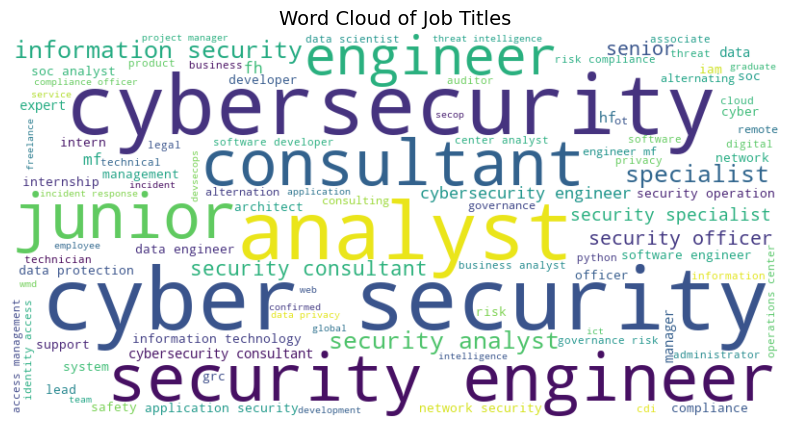

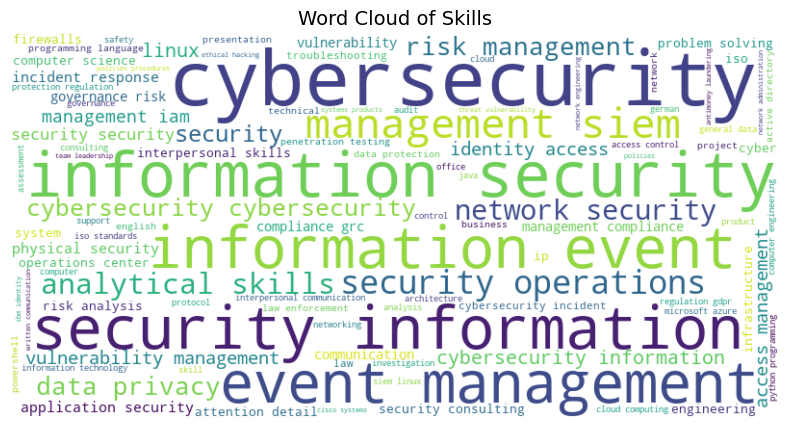

In [54]:
# Generate word clouds
plot_wordcloud(df["Cleaned_Title"], "Word Cloud of Job Titles")
plot_wordcloud(df["Cleaned_Skills"], "Word Cloud of Skills")

In [59]:
df["Location"].value_counts().head(10)

Location
Madrid, Community of Madrid, Spain       87
Paris, Île-de-France, France             81
Milan, Lombardy, Italy                   51
Dublin, County Dublin, Ireland           50
Budapest, Hungary                        48
Spain                                    44
Rome, Latium, Italy                      39
Budapest, Budapest, Hungary              36
Stockholm, Stockholm County, Sweden      33
Amsterdam, North Holland, Netherlands    32
Name: count, dtype: int64

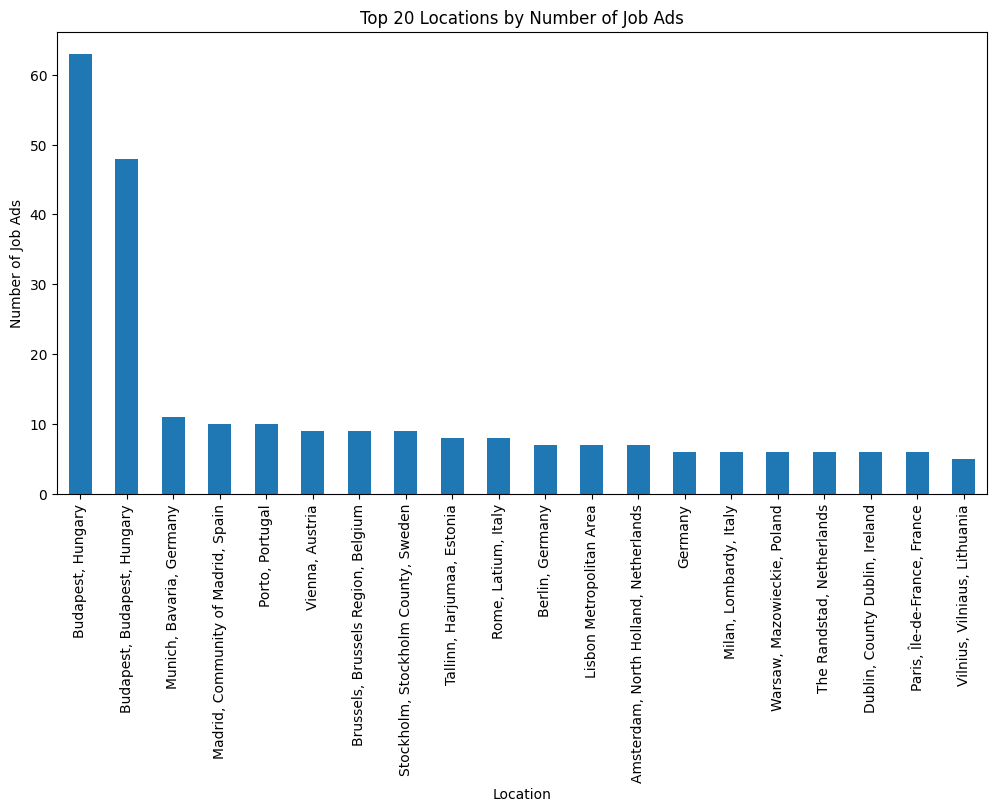

In [136]:
plt.figure(figsize=(12, 6))
df["Location"].value_counts().head(20).plot(kind="bar")
plt.xlabel("Location")
plt.ylabel("Number of Job Ads")
plt.title("Top 20 Locations by Number of Job Ads")
plt.xticks(rotation=90)
plt.show()


In [60]:
# Create a new column 'Country' by extracting the text after the last comma
df["Country"] = df["Location"].apply(lambda x: x.split(",")[-1].strip() if "," in x else x.strip())

# Display the top 10 countries to verify
df["Country"].value_counts().head(10)

Country
France         347
Spain          210
Germany        196
Netherlands    173
Italy          159
Hungary         98
Poland          87
Belgium         83
Portugal        83
Ireland         81
Name: count, dtype: int64

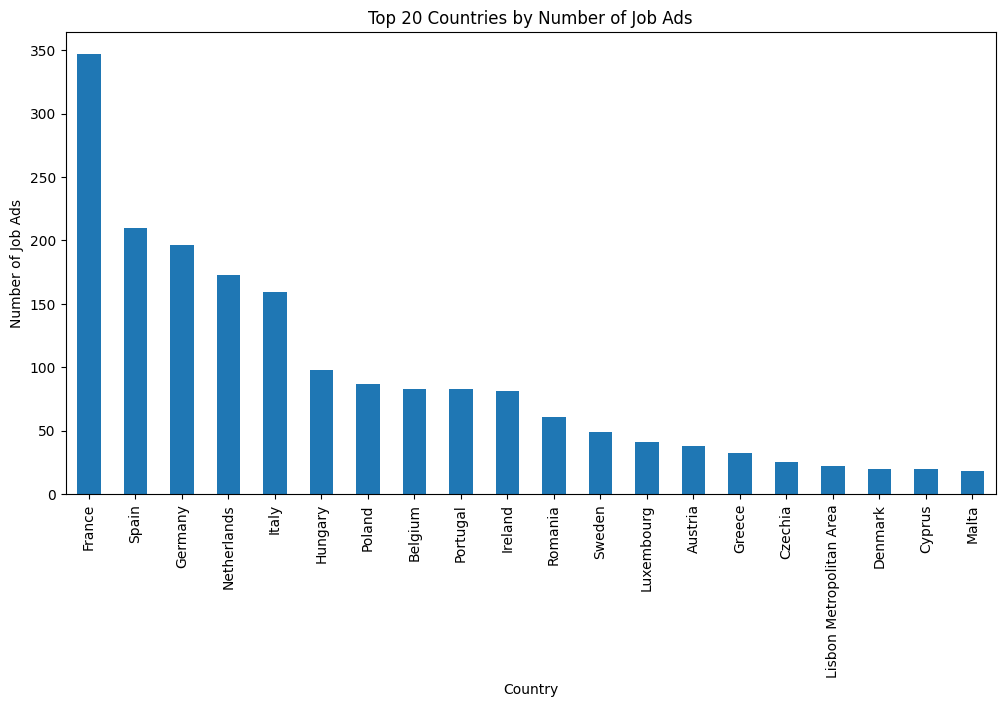

In [61]:
plt.figure(figsize=(12, 6))
df["Country"].value_counts().head(20).plot(kind="bar")
plt.xlabel("Country")
plt.ylabel("Number of Job Ads")
plt.title("Top 20 Countries by Number of Job Ads")
plt.xticks(rotation=90)
plt.show()

In [65]:
import geopandas as gpd

In [ ]:
# Aggregate job counts by country
job_counts = df["Country"].value_counts().reset_index()
job_counts.columns = ["Country", "Job Count"]

In [69]:
shapefile_path = "maps/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
europe = world[world["CONTINENT"] == "Europe"]  # column name is "CONTINENT" in this dataset

In [70]:
europe = europe.merge(job_counts, how="left", left_on="NAME", right_on="Country")  # Use "NAME" for country names

In [71]:
europe["Job Count"] = europe["Job Count"].fillna(0)

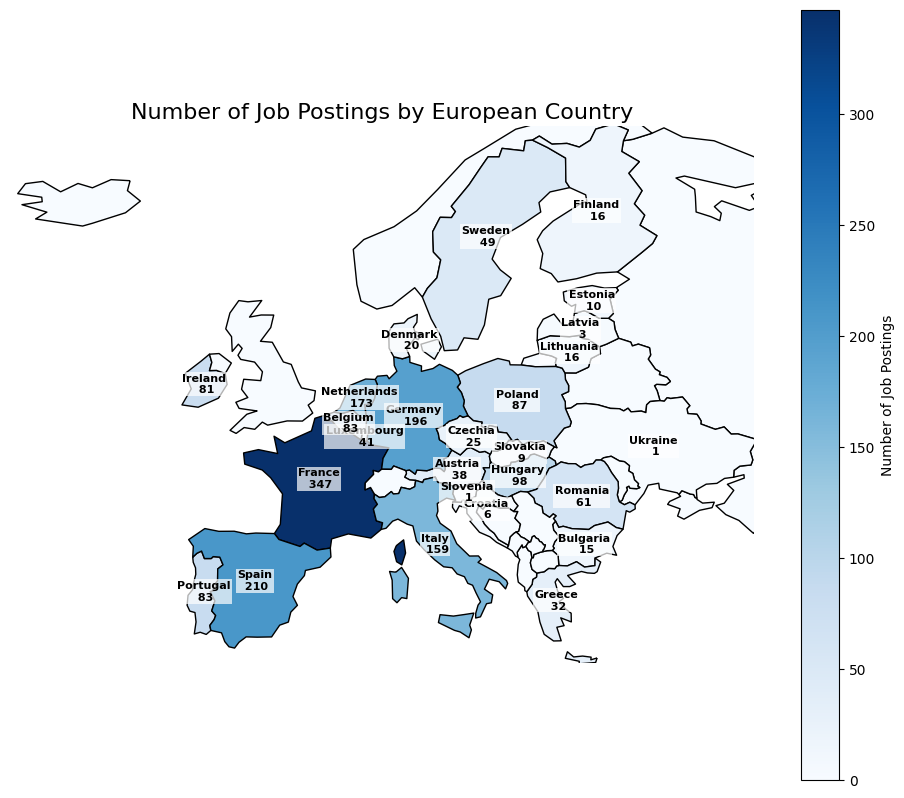

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the choropleth map
europe.plot(
    column="Job Count",
    ax=ax,
    legend=True,
    cmap="Blues",
    edgecolor="black",
    missing_kwds={"color": "lightgrey", "label": "No Jobs"},
    legend_kwds={"label": "Number of Job Postings", "orientation": "vertical"}
)

# Define approximate bounds for Europe (longitude: -25 to 40, latitude: 35 to 70)
ax.set_xlim(-25, 40)  # Longitude range
ax.set_ylim(35, 70)   # Latitude range

for idx, row in europe.iterrows():
    if row["Job Count"] > 0:  # Only label countries with jobs
        # Get the centroid of the country for label placement
        if row["NAME"] == "France":
            centroid_x, centroid_y = 2.0, 47.0
        else: 
            centroid = row.geometry.centroid
            centroid_x, centroid_y = centroid.x, centroid.y
        # Annotate the job count at the centroid
        ax.annotate(
            text=f"{row['NAME']}\n {int(row['Job Count'])}",  # Display country / number of ads
            xy=(centroid_x, centroid_y),  # Position of the label
            ha="center",  # Horizontal alignment: center
            va="center",  # Vertical alignment: center
            fontsize=8,
            color="black",
            weight="bold",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1)  # Add a semi-transparent white background
        )

ax.set_title("Number of Job Postings by European Country", fontsize=16)
ax.set_axis_off()  # Remove axes for a cleaner map

plt.show()

In [86]:
# store state of the DataFrame
with open('df_state.pkl', 'wb') as f:
        pickle.dump(df, f)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties,Cleaned_Title,Cleaned_Skills,Country
865,GRC Specialist - Associate (Remote),SMBC Group is a top-tier global financial grou...,Sumitomo Mitsui Banking Corporation – SMBC Gro...,https://www.linkedin.com/jobs/view/4157824012,"Tralee, County Kerry, Ireland","Communication, Written Communication",60946462,Sumitomo Mitsui Banking Corporation – SMBC Group,None,None,None,NaN,None,grc specialist associate remote,communication written communication,Ireland
819,Chef / project manager IT MOA Fight against fraud,"Chef / IT Moa project manager fights fraud, yo...","La Banque Postale · Issy-les-Moulineaux, Île-d...",https://www.linkedin.com/jobs/view/4187451165,"Issy-les-Moulineaux, Île-de-France, France","Artificial Intelligence (AI), SI",380000697,La Banque Postale,None,None,None,NaN,None,chef project manager moa fight fraud,artificial intelligence,France
382,Business Intelligence Specialist,Skills & Experience: 4+ years’ experience as a...,"Harvey Nash · Longford, County Longford, Irela...",https://www.linkedin.com/jobs/view/4171839921,"Longford, County Longford, Ireland",,723067619,Harvey Nash,"We’re Harvey Nash, and we build amazing techno...",http://www.harveynash.com,Staffing & Recruiting,3078.0,"Executive Search & Leadership Services,Outsour...",business intelligence specialist,,Ireland
584,Customer Success Manager - Cyber Security,"Our client, a leading cybersecurity vendor, is...","Fruition Group · Madrid, Community of Madrid, ...",https://www.linkedin.com/jobs/view/4178407430,"Madrid, Community of Madrid, Spain","Customer Success, Customer Relationship Manage...",9443063,Fruition Group,None,None,None,NaN,None,customer success manager cyber security,customer success customer relationship managem...,Spain
1709,Cyber Security Architect – EU institutions/Gov...,Cyber Security Architect – EU institutions/Gov...,"Empiric · Luxembourg, Luxembourg (Hybrid)",https://www.linkedin.com/jobs/view/4189694716,"Luxembourg, Luxembourg","Security Architecture Design, Cybersecurity",608142402,Empiric,None,None,None,NaN,None,cyber security architect eu institutionsgovern...,security architecture design cybersecurity,Luxembourg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,Identity Management Consultant,Role :Sailpoint IAM (identity access mngt) Dev...,Skywaves Rise · Germany (Remote),https://www.linkedin.com/jobs/view/4197057123,Germany,"LDAP, SailPoint",567455602,Skywaves Rise,None,None,None,NaN,None,identity management consultant,ldap sailpoint,Germany
1095,Security Analyst - Tier 2 (all humans),Make a difference in the financial life of mil...,"First digital · Inner city, Vienna, Austria (h...",https://www.linkedin.com/jobs/view/4175511615,"Innere Stadt, Vienna, Austria","Digital Authentication, Security Operations",753699953,Erste Digital,None,None,None,NaN,None,security analyst tier humans,digital authentication security operations,Austria
1130,Identity and Access Management Analyst,Identity and Access Management (IAM) Analyst. ...,"Stanley Black & Decker, Inc. Warsaw, Mazowieck...",https://www.linkedin.com/jobs/view/4194942639,"Warsaw, Mazowieckie, Poland","Identity and Access Management (IAM), Analytic...",20803989,"Stanley Black & Decker, Inc.",None,None,None,NaN,None,identity access management analyst,identity access management iam analytical skills,Poland
1294,Employee Security Service (m/f/d),Chat application ». Location: 68549 Ilvesheim ...,"Rewe · Ilvesheim, Baden-Württemberg, Germany",https://www.linkedin.com/jobs/view/4195830803,"Ilvesheim, Baden-Württemberg, Germany","Security, Personnel Security",183313548,REWE,None,None,None,NaN,None,employee security service,security personnel security,Germany


In [100]:
def clean_and_standardize_skills(skills_str):
    if not isinstance(skills_str, str) or skills_str.strip() == "":
        return []  # Return empty list for empty or non-string values
    # Split by comma, strip whitespace, and standardize
    skills = [skill.strip() for skill in skills_str.split(",") if skill.strip()]
    # Standardize cyber security variations
    standardized_skills = []
    for skill in skills:
        skill = skill.lower()  # Convert to lowercase for consistency
        if any(var in skill for var in ["cybersecurity", "cyber-security", "cyber security"]):
            standardized_skills.append("cyber security")
        else:
            standardized_skills.append(skill)
    return standardized_skills

In [101]:
df["Skills_List"] = df["Skill"].apply(clean_and_standardize_skills)

In [102]:
all_skills = df["Skills_List"].explode().dropna().reset_index(drop=True)

In [104]:
print("First rows of Skills_List:")
print(df[["Skill", "Skills_List"]].head())

First rows of Skills_List:
                                                  Skill  \
865                Communication, Written Communication   
819                    Artificial Intelligence (AI), SI   
382                                                       
584   Customer Success, Customer Relationship Manage...   
1709        Security Architecture Design, Cybersecurity   

                                            Skills_List  
865              [communication, written communication]  
819                  [artificial intelligence (ai), si]  
382                                                  []  
584   [customer success, customer relationship manag...  
1709     [security architecture design, cyber security]  


In [105]:
print("\nSkills and their frequencies:")
print(all_skills.value_counts().head(10))


Skills and their frequencies:
Skills_List
cyber security                                      446
security information and event management (siem)    159
information security                                152
analytical skills                                    88
security operations                                  85
network security                                     84
data privacy                                         66
linux                                                63
risk management                                      50
vulnerability                                        48
Name: count, dtype: int64


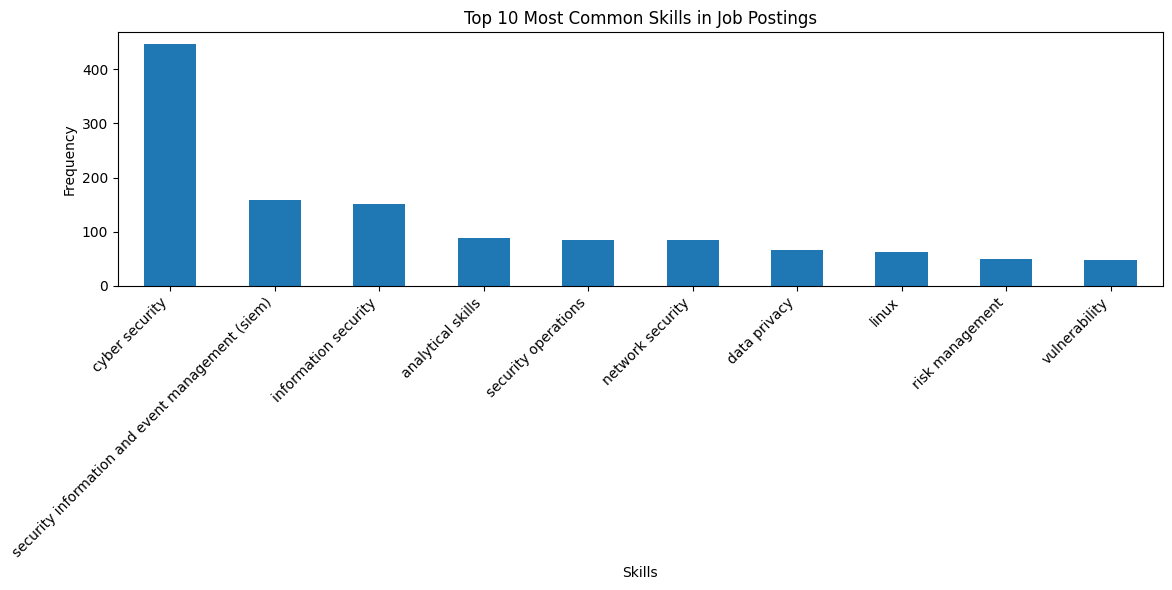

In [106]:
# Bar Chart of Top Skills
top_skills = all_skills.value_counts().head(10)
plt.figure(figsize=(12, 6))
top_skills.plot(kind="bar")
plt.title("Top 10 Most Common Skills in Job Postings")
plt.xlabel("Skills")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

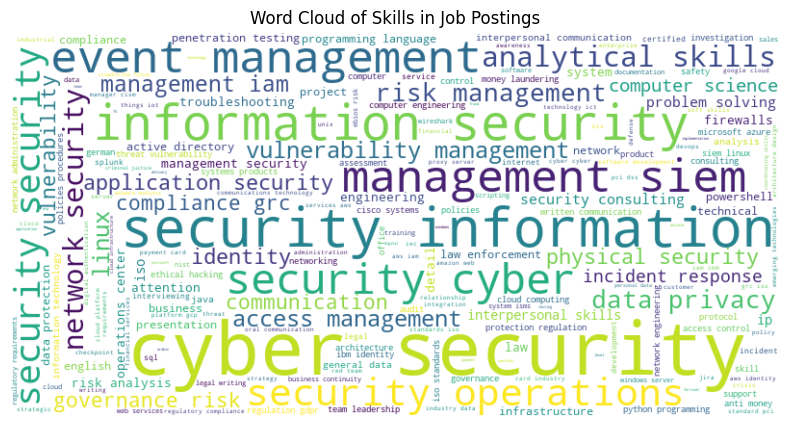

In [107]:
# Word Cloud of Skills (preprocessed and standarized)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_skills))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud of Skills in Job Postings")
plt.axis("off")
plt.show()

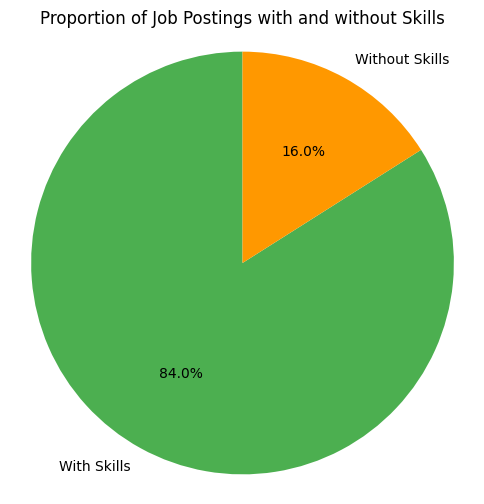

In [108]:
# Pie Chart of Jobs with vs. Without Skills
has_skills = (df["Skills_List"].str.len() > 0).value_counts()
plt.figure(figsize=(6, 6))
plt.pie(has_skills, labels=["With Skills", "Without Skills"], colors=["#4CAF50", "#FF9800"], autopct="%1.1f%%", startangle=90)
plt.title("Proportion of Job Postings with and without Skills")
plt.axis("equal")
plt.show()